<a href="https://colab.research.google.com/github/utamiu1807/Recitation_minilab_ML/blob/main/Copy_of_Utami_ML_Foundations_Classification_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from google.colab import drive
from google.colab import files

## Read Dataset

In [69]:
data = pd.read_csv('https://www.dropbox.com/scl/fi/lle2wyziwywf8kxaq56na/telco_churn.csv?rlkey=kh9571prkkg8uki7mahnwunml&st=da4ou0gy&dl=1')

data.head()

,CustomerID,Country,State,City,ZipCode,LatLong,Latitude,Longitude,Gender,SeniorCitizen,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel,ChurnValue,CLTV,ChurnReason
0,5018-LXQQG,United States,California,Torrance,90505,"33.807882, -118.347957",33.807882,-118.347957,Female,No,...,Yes,Month-to-month,No,Bank transfer (automatic),66.30,1923.50,No,0,4631,NaN
1,4452-QIIEB,United States,California,Glendora,91740,"34.119363, -117.855059",34.119363,-117.855059,Male,No,...,No,Month-to-month,No,Mailed check,43.90,278.40,No,0,3565,NaN
2,4176-RELJR,United States,California,Elmira,95625,"38.349195, -121.902943",38.349195,-121.902943,Male,Yes,...,No internet service,Two year,No,Credit card (automatic),25.10,1672.15,No,0,6388,NaN
3,5229-PRWKT,United States,California,Lompoc,93437,"34.757477, -120.550507",34.757477,-120.550507,Male,No,...,Yes,Month-to-month,Yes,Electronic check,86.55,649.65,Yes,1,4193,Attitude of service provider
4,4138-NAXED,United States,California,Joshua Tree,92252,"34.167236, -116.281511",34.167236,-116.281511,Male,No,...,No,Month-to-month,No,Bank transfer (automatic),81.00,4085.75,No,0,4121,NaN


## Data Exploration and Pre-processing

In [70]:
# Drop unnecessary columns
data = data.drop(['Country', 'State', 'ChurnReason', 'ChurnLabel', "CustomerID"], axis=1)

In [71]:
data.shape

(6043, 26)

In [72]:
# Show all columns that have missing values
data.columns[data.isnull().any()]

Index(['TotalCharges'], dtype='object')

In [73]:
# Drop rows with missing values
data = data.dropna()
data.shape

(6032, 26)

In [74]:
# Starter predictor variables #try drop churn value
#selected_columns = ["TenureMonths","Contract","MonthlyCharges","InternetService","TechSupport","ChurnValue"]

#data = data[selected_columns]

In [75]:
# Your exploration here
#---GROUP 1: CONTRACT FEATURES ---
data['Is_MonthlyContract'] = (data['Contract'] == 'Month-to-month').astype(int)
data['Is_TwoYearContract'] = (data['Contract'] == 'Two year').astype(int)

# --- GROUP 2: FINANCIAL FEATURES ---
# Ratio of actual charges vs expected (TenureMonths * Monthly) — <1 means discount, >1 means overpaying
data['ChargeRatio'] = data['TotalCharges'] / (data['TenureMonths'] * data['MonthlyCharges'] + 1)
# Average monthly spend (smoothed to avoid division by zero)
data['AvgMonthlyCharge'] = data['TotalCharges'] / (data['TenureMonths'] + 1)
# Flag customers in the top 25% for monthly charges
high_threshold = data['MonthlyCharges'].quantile(0.75)
data['HighCharges'] = (data['MonthlyCharges'] >= high_threshold).astype(int)

# --- GROUP 3: SERVICE BUNDLE FEATURES ---
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_cols:
    data[col + '_bin'] = (data[col] == 'Yes').astype(int)

data['NumServices'] = data[[c + '_bin' for c in service_cols]].sum(axis=1)
data['HasStreaming'] = ((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')).astype(int)
data['HasSupport'] = ((data['OnlineSecurity'] == 'Yes') | (data['TechSupport'] == 'Yes')).astype(int)

# --- GROUP 4: LIFECYCLE / INTERACTION FEATURES ---
# Bucket customers into early, mid, loyal
data['TenureBucket'] = pd.cut(data['TenureMonths'], bins=[0, 12, 36, 72],
                               labels=['New', 'Mid', 'Loyal']).astype(str)
# Interaction: tenure × monthly charges captures high-paying new customers
data['Tenure_x_MonthlyCharge'] = data['TenureMonths'] * data['MonthlyCharges']
data['Tenure_Contract_Interaction'] = data['TenureMonths'] * data['Is_MonthlyContract']
# Highest-risk segment: new + no commitment + high bill
data['HighRiskFlag'] = ((data['TenureMonths'] < 12) &
                        (data['Is_MonthlyContract'] == 1) &
                        (data['HighCharges'] == 1)).astype(int)

# --- GROUP 5: PAYMENT / BILLING ---
data['ElectronicCheck'] = (data['PaymentMethod'] == 'Electronic check').astype(int)
data['PaperlessBilling_bin'] = (data['PaperlessBilling'] == 'Yes').astype(int)
data['HasFiber'] = (data['InternetService'] == 'Fiber optic').astype(int)
data['HasInternet'] = (data['InternetService'] != 'No').astype(int)

print('Total columns after feature engineering:', data.shape[1])
print('New features added:', data.shape[1] - 21)  # original had 21 after dropping


Total columns after feature engineering: 48
New features added: 27


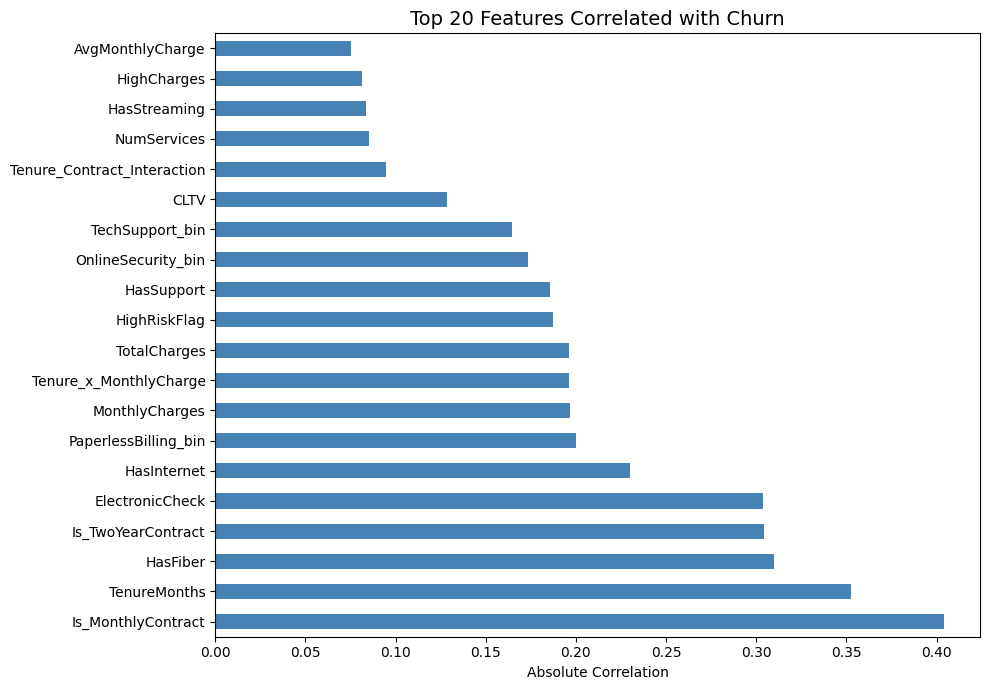

Top 10 correlated features:
Is_MonthlyContract        0.404
TenureMonths              0.352
HasFiber                  0.310
Is_TwoYearContract        0.304
ElectronicCheck           0.304
HasInternet               0.230
PaperlessBilling_bin      0.200
MonthlyCharges            0.197
Tenure_x_MonthlyCharge    0.196
TotalCharges              0.196


In [76]:
numeric_data = data.select_dtypes(include=[np.number])
correlations = numeric_data.corr()['ChurnValue'].drop('ChurnValue').abs().sort_values(ascending=False)

plt.figure(figsize=(10, 7))
correlations.head(20).plot(kind='barh', color='steelblue')
plt.title('Top 20 Features Correlated with Churn', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

print('Top 10 correlated features:')
print(correlations.head(10).round(3).to_string())


In [77]:
# Final feature selection
selected_columns = [
    # Core numeric
    'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
    # Contract
    'Is_MonthlyContract', 'Is_TwoYearContract',
    # Financial
    'ChargeRatio', 'AvgMonthlyCharge', 'HighCharges',
    # Services
    'NumServices', 'HasStreaming', 'HasSupport',
    'OnlineSecurity_bin', 'TechSupport_bin', 'OnlineBackup_bin',
    # Lifecycle interactions
    'Tenure_x_MonthlyCharge', 'Tenure_Contract_Interaction', 'HighRiskFlag',
    # Payment
    'ElectronicCheck', 'PaperlessBilling_bin',
    # Internet
    'HasFiber', 'HasInternet',
    # Categoricals to encode
    'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'Contract', 'TenureBucket',
    # Target
    'ChurnValue'
]

data = data[selected_columns].copy()

# Convert SeniorCitizen to numeric (0 or 1)
data['SeniorCitizen'] = data['SeniorCitizen'].map({'Yes': 1, 'No': 0}).astype(int)

# One-hot encode categoricals
data = pd.get_dummies(data, columns=['Gender', 'Partner', 'Dependents', 'PhoneService',
                                   'MultipleLines', 'InternetService', 'Contract', 'TenureBucket'],
                    drop_first=True)

In [78]:
data

,TenureMonths,MonthlyCharges,TotalCharges,SeniorCitizen,Is_MonthlyContract,Is_TwoYearContract,ChargeRatio,AvgMonthlyCharge,HighCharges,NumServices,...,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,TenureBucket_Mid,TenureBucket_New
0,30,66.30,1923.50,0,1,0,0.966583,62.048387,0,3,...,True,True,False,False,False,False,False,False,True,False
1,7,43.90,278.40,0,1,0,0.903017,34.800000,0,0,...,False,True,False,False,False,False,False,False,False,True
2,67,25.10,1672.15,1,0,1,0.993730,24.590441,0,0,...,False,True,False,True,False,True,False,True,False,False
3,8,86.55,649.65,0,1,0,0.936905,72.183333,0,1,...,False,True,False,True,True,False,False,False,False,True
4,51,81.00,4085.75,0,1,0,0.988807,78.572115,0,1,...,False,True,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6038,42,100.40,4303.65,0,0,1,1.020354,100.084884,1,4,...,True,True,False,False,True,False,False,True,False,False
6039,39,20.70,762.45,0,0,1,0.943276,19.061250,0,0,...,False,True,False,False,False,True,False,True,False,False
6040,19,20.20,387.40,0,0,1,1.006757,19.370000,0,0,...,True,True,False,False,False,True,False,True,True,False
6041,35,19.90,666.00,0,0,0,0.954839,18.500000,0,0,...,True,True,False,False,False,True,True,False,True,False


## Split Train and Test

In [79]:
# Convert categorical features to numerical using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

# Define features (X) and target (y)
X = data.drop('ChurnValue', axis=1)
y = data['ChurnValue']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.772162386081193


## Logistic Regression

Accuracy: 0.7986743993371996

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       900
           1       0.61      0.57      0.59       307

    accuracy                           0.80      1207
   macro avg       0.73      0.72      0.73      1207
weighted avg       0.79      0.80      0.80      1207



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


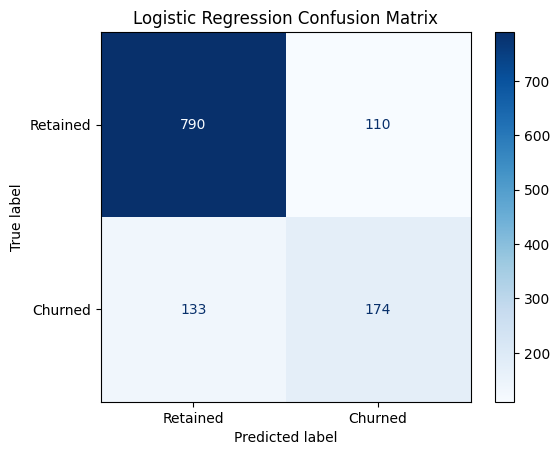

In [81]:
# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained', 'Churned'])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [82]:
feature_names = data.drop('ChurnValue', axis=1).columns

coefficients = model.coef_[0]

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df

,Feature,Coefficient
0,TenureMonths,-0.131765
1,MonthlyCharges,0.023732
2,TotalCharges,-0.001636
3,SeniorCitizen,0.051928
4,Is_MonthlyContract,-0.041535
5,Is_TwoYearContract,-0.041951
6,ChargeRatio,-0.092515
7,AvgMonthlyCharge,-0.009225
8,HighCharges,0.020138
9,NumServices,-0.120309


## K Nearest Neighbors

KNN Accuracy: 0.7787903893951947

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       900
           1       0.62      0.33      0.43       307

    accuracy                           0.78      1207
   macro avg       0.71      0.63      0.65      1207
weighted avg       0.76      0.78      0.75      1207



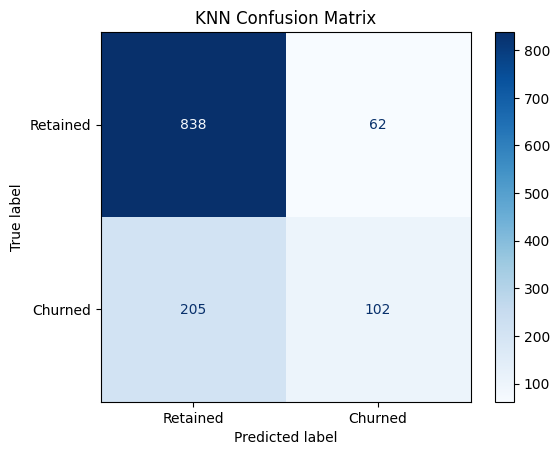

In [83]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=20)  # You can adjust n_neighbors

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
knn_y_pred = knn_model.predict(X_test)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, knn_y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, knn_y_pred))

cm = confusion_matrix(y_test, knn_y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained', 'Churned'])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()

## Random Forest

Random Forest Accuracy: 0.7862468931234465

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       900
           1       0.60      0.48      0.53       307

    accuracy                           0.79      1207
   macro avg       0.72      0.68      0.70      1207
weighted avg       0.77      0.79      0.78      1207



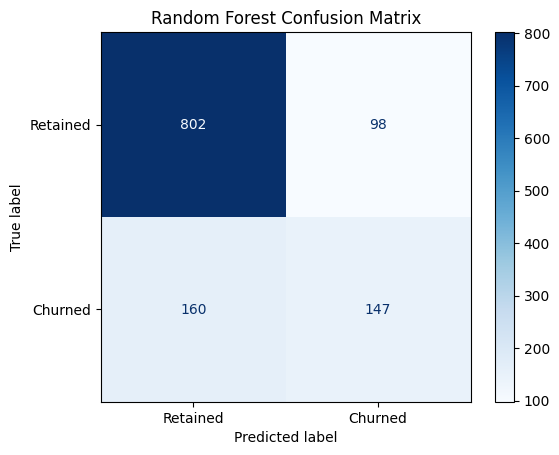

In [84]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_y_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_y_pred))

cm = confusion_matrix(y_test, rf_y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained', 'Churned'])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

## Make Predictions on Unknown Data

In [85]:
prediction_data = pd.read_csv('https://www.dropbox.com/scl/fi/o4g2rytrm9off6rroh233/telco_churn_test_data.csv?rlkey=xpe5qjslooe1y79p1esjd7ps2&st=lots4ru3&dl=1')

prediction_data.head()

,CustomerID,Country,State,City,ZipCode,LatLong,Latitude,Longitude,Gender,SeniorCitizen,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel,ChurnValue,CLTV,ChurnReason
0,2189-WWOEW,United States,California,Keene,93531,"35.214982, -118.59049",35.214982,-118.590490,Female,No,...,Yes,Month-to-month,Yes,Bank transfer (automatic),85.9,1269.55,NaN,NaN,3579,NaN
1,2446-ZKVAF,United States,California,Stockton,95207,"38.002125, -121.324979",38.002125,-121.324979,Male,No,...,No,Month-to-month,No,Credit card (automatic),56.8,1074.65,NaN,NaN,5558,NaN
2,4986-MXSFP,United States,California,San Leandro,94579,"37.687264, -122.15728",37.687264,-122.157280,Female,No,...,No internet service,Month-to-month,Yes,Mailed check,20.0,40.90,NaN,NaN,2237,NaN
3,5868-YWPDW,United States,California,Sherman Oaks,91423,"34.146957, -118.432138",34.146957,-118.432138,Male,Yes,...,Yes,Month-to-month,Yes,Electronic check,84.2,519.15,NaN,NaN,5834,NaN
4,9412-GHEEC,United States,California,Murrieta,92563,"33.581045, -117.14719",33.581045,-117.147190,Male,No,...,Yes,Month-to-month,No,Bank transfer (automatic),104.8,4131.95,NaN,NaN,3492,NaN


In [86]:
prediction_data = pd.read_csv('https://www.dropbox.com/scl/fi/o4g2rytrm9off6rroh233/telco_churn_test_data.csv?rlkey=xpe5qjslooe1y79p1esjd7ps2&st=lots4ru3&dl=1')

def apply_feature_engineering(df, training_cols, fitted_scaler):
    drop_cols = ['CustomerID', 'Country', 'State', 'City', 'ZipCode',
                 'LatLong', 'Latitude', 'Longitude', 'ChurnLabel', 'ChurnReason']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

    # Convert SeniorCitizen to numeric (0 or 1) - THIS WAS MISSING
    df['SeniorCitizen'] = df['SeniorCitizen'].map({'Yes': 1, 'No': 0}).astype(int)

    df['Is_MonthlyContract'] = (df['Contract'] == 'Month-to-month').astype(int)
    df['Is_TwoYearContract'] = (df['Contract'] == 'Two year').astype(int)
    df['ChargeRatio'] = df['TotalCharges'] / (df['TenureMonths'] * df['MonthlyCharges'] + 1)
    df['AvgMonthlyCharge'] = df['TotalCharges'] / (df['TenureMonths'] + 1)
    high_threshold_val = 89.85 # From kernel state: high_threshold = data['MonthlyCharges'].quantile(0.75)
    df['HighCharges'] = (df['MonthlyCharges'] >= high_threshold_val).astype(int)

    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in service_cols:
        df[col + '_bin'] = (df[col] == 'Yes').astype(int)
    df['NumServices'] = df[[c + '_bin' for c in service_cols]].sum(axis=1)
    df['HasStreaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).astype(int)
    df['HasSupport'] = ((df['OnlineSecurity'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)
    df['TenureBucket'] = pd.cut(df['TenureMonths'], bins=[0, 12, 36, 72],
                                 labels=['New', 'Mid', 'Loyal']).astype(str)
    df['Tenure_x_MonthlyCharge'] = df['TenureMonths'] * df['MonthlyCharges']
    df['Tenure_Contract_Interaction'] = df['TenureMonths'] * df['Is_MonthlyContract']
    df['HighRiskFlag'] = ((df['TenureMonths'] < 12) &
                        (df['Is_MonthlyContract'] == 1) &
                        (df['HighCharges'] == 1)).astype(int)
    df['ElectronicCheck'] = (df['PaymentMethod'] == 'Electronic check').astype(int)
    df['PaperlessBilling_bin'] = (df['PaperlessBilling'] == 'Yes').astype(int)
    df['HasFiber'] = (df['InternetService'] == 'Fiber optic').astype(int)
    df['HasInternet'] = (df['InternetService'] != 'No').astype(int)

    df = pd.get_dummies(df, columns=['Gender', 'Partner', 'Dependents', 'PhoneService',
                                      'MultipleLines', 'InternetService', 'Contract', 'TenureBucket'],
                        drop_first=True)
    if 'ChurnValue' in df.columns:
        df = df.drop('ChurnValue', axis=1)
    df = df.reindex(columns=training_cols, fill_value=0)
    return fitted_scaler.transform(df)

X_pred = apply_feature_engineering(prediction_data.copy(), X.columns, scaler)

In [87]:
# Predict outcomes on new dataset

prediction_data['ChurnValue'] = model.predict(X_pred)
prediction_data['Churn_Probability'] = model.predict_proba(X_pred)[:, 1]

prediction_data.head()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,CustomerID,Country,State,City,ZipCode,LatLong,Latitude,Longitude,Gender,SeniorCitizen,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel,ChurnValue,CLTV,ChurnReason,Churn_Probability
0,2189-WWOEW,United States,California,Keene,93531,"35.214982, -118.59049",35.214982,-118.590490,Female,No,...,Month-to-month,Yes,Bank transfer (automatic),85.9,1269.55,NaN,1,3579,NaN,0.625880
1,2446-ZKVAF,United States,California,Stockton,95207,"38.002125, -121.324979",38.002125,-121.324979,Male,No,...,Month-to-month,No,Credit card (automatic),56.8,1074.65,NaN,0,5558,NaN,0.459717
2,4986-MXSFP,United States,California,San Leandro,94579,"37.687264, -122.15728",37.687264,-122.157280,Female,No,...,Month-to-month,Yes,Mailed check,20.0,40.90,NaN,0,2237,NaN,0.467566
3,5868-YWPDW,United States,California,Sherman Oaks,91423,"34.146957, -118.432138",34.146957,-118.432138,Male,Yes,...,Month-to-month,Yes,Electronic check,84.2,519.15,NaN,1,5834,NaN,0.627155
4,9412-GHEEC,United States,California,Murrieta,92563,"33.581045, -117.14719",33.581045,-117.147190,Male,No,...,Month-to-month,No,Bank transfer (automatic),104.8,4131.95,NaN,0,3492,NaN,0.492452


In [88]:
# if the column Churn_Probability is in the top 30% of the dataframe assign it to a variable "ChurnCategory"

churn_threshold = prediction_data['Churn_Probability'].quantile(0.7)
prediction_data.loc[prediction_data['Churn_Probability'] >= churn_threshold, "ChurnCategory"] = "High"

In [89]:
# Save files for adding to Google Sheets

prediction_data.to_csv('team_predictions.csv', index=False)
files.download('team_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ML Foundations Spring 2026

[Post your ChurnValue Predictions to Google Sheets](https://docs.google.com/spreadsheets/d/11-usI5vKD-VmTgcY2jYElBHxJtO_KLp411tuYb79vh4/edit?usp=sharing)